# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/af/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
 
# plotDir = '/storage/af/user/jmao/gpu/jmao/cms-llp/plots/20210312/v0/'
plotDir = '/storage/af/user/jmao/gpu/jmao/cms-llp/plots/20210706/v0/'

os.system("mkdir -p "+ plotDir)

0

# Signal part

In [3]:
tags = []
tags = [
    
        'H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m',
        'H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m',
        'H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m',
    
        ]


# directory
home_dir = '/storage/cms/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v42/'
# file names

fnames = {}


fnames['H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m'] = 'MC_Fall18/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m'] = 'MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m'] = 'MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'

 
# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/storage/cms/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v42/MC_Fall18/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fcbdba8bd30> OrderedDict([('H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fcbdba8bd30>)])
[[0.0061251214 0.7019389] [0.4609478] [0.18089193 0.0034968085 0.0] ... [0.3462483] [0.0076019447] [0.0021862527]]
[8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06
 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06]
[8.06029e-06]
/storage/cms/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v42/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fcbdb5c1be0> OrderedDict([('H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fcbdba8bd30>), ('H(bb)H(bb) 2017, 200 Ge

# 0 lep region

In [4]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mdphi_cut=0.5
do_mdphi=0
do_mdphi_2p4=1
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}
trg_jet_dnn = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

ECAL_R=129.0 #cm
EB_Z=268.3 #cm
trg_jet_ctau = {}
trg_jet_eb = {}
trg_jet_tagged = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    if do_mdphi_2p4==1:
        mdphi = v['jetMet_dPhiMin_eta_2p4'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
#     llp_r = v['gLLP_decay_vertex_r'].array()
#     llp_z = v['gLLP_decay_vertex_z'].array()
    if 'H(bb)' in k:
        llp_tagged = v['gLLP_tagged'].array()
        llp_eb = v['gLLP_eb'].array()
        llp_ctau = v['gLLP_ctau'].array()
    
#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    dnn = v['jetDNNScoreV3'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
    if do_mdphi==1:
        met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
    if do_mdphi_2p4==1:
        met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     if 'H(bb)' in k:
#         met_trg_str = np.logical_and(basic_met_str, np.sum(llp_eb,axis = 1) > 0) 

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
    if 'H(bb)' in k:
        trg_jet_ctau[k] = llp_ctau[met_trg_str]
        trg_jet_eb[k] = llp_eb[met_trg_str]
        trg_jet_tagged[k] = llp_tagged[met_trg_str]
        

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]
    
    trg_jet_dnn[k] = dnn[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]
    if 'H(bb)' in k:
        trg_jet_ctau[k] = trg_jet_ctau[k][trg_jet_pt[k].count()>njet_cut]
        trg_jet_eb[k] = trg_jet_eb[k][trg_jet_pt[k].count()>njet_cut]
        trg_jet_tagged[k] = trg_jet_tagged[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]
    
    trg_jet_dnn[k] = trg_jet_dnn[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))
    print(len(trg_jet_pt[k]))
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_eb[k]))
    print(len(trg_jet_tagged[k]))
    print(len(trg_jet_dnn[k]))
#     print(trg_jet_ctau[k][:10])
#     print(trg_jet_eb[k][:10])

    

H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdba8bd30>
(3502,)
2404
2404
2404
2404
2404
2404
2404
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdb5c1be0>
(3595,)
2407
2407
2407
2407
2407
2407
2407
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdb052278>
(3520,)
2420
2420
2420
2420
2420
2420
2420


# Tags

In [5]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

dnn_cut=0.996

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
#     tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    tagged_jet = np.logical_and(1, trg_jet_dnn[k]>dnn_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdba8bd30>
[[196.69899 65.40026] [541.091 344.1413 87.39241] [367.50134] ... [236.77806 46.18347 38.05413] [101.16123 58.71563 42.667877] [66.70066 41.127144 30.204514]]
[[196.69899] [] [] ... [] [101.16123] []]
[[65.40026] [541.091 344.1413 87.39241] [367.50134] ... [236.77806 46.18347 38.05413] [58.71563 42.667877] [66.70066 41.127144 30.204514]]
[0 1 2 3 4 5 6]
[0 1 2 3]
[0 1 2]
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdb5c1be0>
[[282.457 162.11057] [125.18975 99.24258 31.894602] [] ... [200.32048] [352.38376] [172.29527]]
[[] [] [] ... [] [352.38376] []]
[[282.457 162.11057] [125.18975 99.24258 31.894602] [] ... [200.32048] [] [172.29527]]
[0 1 2 3 4 5 6]
[0 1 2 3]
[0 1 2]
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdb052278>
[[252.15971] [311.2517 288.1564 59.003414] [] ... [138.20229 56.830166] [] [409.05798 224.43147 119.83973]]
[[252.15971] [] [] ... [] [] []]
[

# CTAU plot

In [6]:
variables=[
#      ['jetTime', trg_jet_time, 50, -13, 13],
     ['LLP_ctau_cm', trg_jet_ctau, 50, 0, 1000],
#      ['LLP_ctau_tagged', trg_jet_ctau, 50, 0, 1000],
]

var/x_axis LLP_ctau_cm binning 50 0 1000
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
[8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06
 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06]
180
180
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m 1
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
248
248
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m 2
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
210
210
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m 4
137.0 fb^{-1} (13 TeV)


Info in <TCanvas::Print>: png file /storage/af/user/jmao/gpu/jmao/cms-llp/plots/20210706/v0/LLP_ctau_cm_bin2.png has been created


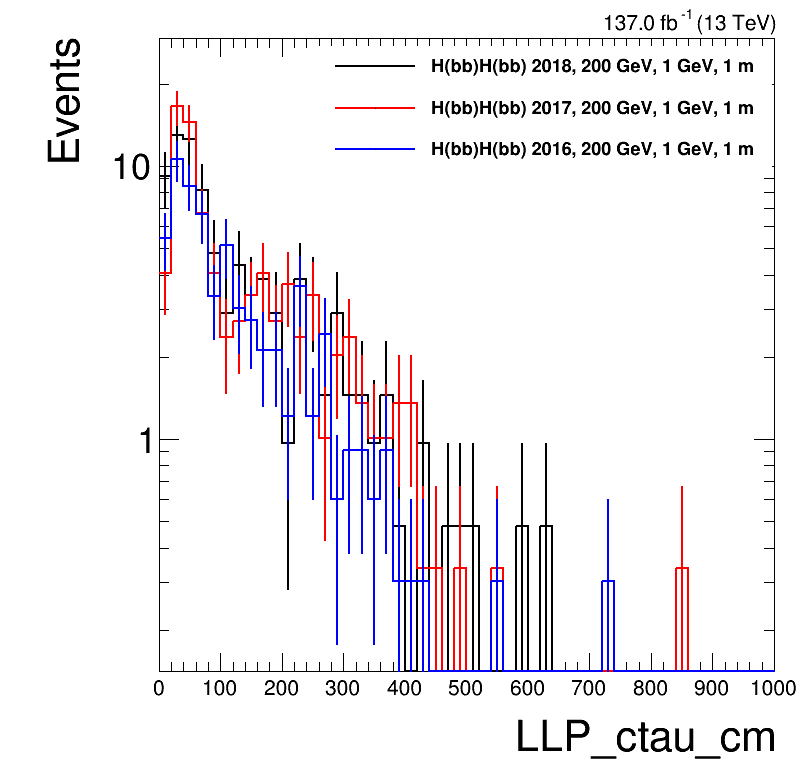

In [7]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    outf=var[0]+'_bin2.png'
#     outf=var[0]+'.png'
    LUMI = 137000 
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    
    color_list = [845,806,861,876,597,625]
    
    i=0
    for k,v in tree.items():
        if '2016' in k:
            lumi=35922
        elif '2017' in k:
            lumi=41529
        elif '2018' in k:
            lumi=59740
        print(k)
        pt1 = var[1][k][nTags[k]==2] 
        v = pt1.flatten()
#         print(v[:10])
#         print(trg_jet_tagged[k][:10])
#         print(trg_jet_ctau[k][:10])
        w = np.array([[x]*len(y) for x,y in zip(trg_jet_w[k][nTags[k]==2],var[1][k][nTags[k]==2] )])
        w = w.flatten()
#         w = trg_jet_w[k] 
        print(w[:10])
        print(len(v))
        print(len(w))
#         w = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)

        i+=1

   
    leg.Draw()



    CMS_lumi.lumi_13TeV = str(LUMI/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
#     c.SetLogx()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

In [8]:
trg_tag_ctau = {}
trg_tag_w = {}
ex_nTags = {}
ex_ws = {}

for k,v in tree.items():
    print(k,v)
    
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_w[k]))
    print(len(trg_jet_tagged[k]))
    
    print(trg_jet_ctau[k][:10])
    print(trg_jet_tagged[k][:10])
    
    
    ex_nTags[k] = np.array([[x,x] for x in nTags[k]])
    ex_ws[k] = np.array([[x,x] for x in trg_jet_w[k]])
    print(ex_nTags[k][:10])

    tagged_str = np.logical_and( trg_jet_tagged[k]==True, ex_nTags[k]==2)
    trg_tag_ctau[k]= trg_jet_ctau[k][tagged_str]
    trg_tag_w[k]= ex_ws[k][tagged_str]
    

    print(trg_tag_ctau[k][:10])
    print(trg_tag_w[k][:10])
    
    print(len(trg_tag_ctau[k]))
    print(len(trg_tag_w[k]))
    

H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdba8bd30>
2404
2404
2404
[[359.9728      63.71148   ]
 [192.60222      7.54669   ]
 [381.4281      44.12098   ]
 [103.72642     22.408777  ]
 [160.21768     41.35944   ]
 [350.17694      0.62276983]
 [145.11092     13.467606  ]
 [128.73936     97.55039   ]
 [389.46167     38.52371   ]
 [185.74974     80.97106   ]]
[[False  True]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False False]]
[[1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]]
[ 46.79363   98.10104   10.440813 105.71379   57.35336   76.39416
  43.316196  21.199297  66.94743   54.766487]
[8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06
 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06]
77
77
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbdb5c1be0>
2407
2407
2407
[[160.60211     4.173067 ]
 [ 28.563137  221.15602  ]
 [ 62.

In [12]:
variables=[
#      ['jetTime', trg_jet_time, 50, -13, 13],
#      ['LLP_ctau_cm', trg_jet_ctau, 50, 0, 1000],
     ['LLP_ctau_tagged', trg_tag_ctau, 50, 0, 1000],
#      ['LLP_ctau_tagged', trg_tag_ctau, 50, 0, 100],
]

In [9]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    outf=var[0]+'_bin2.png'
#     outf=var[0]+'_bin2_1m.png'
#     outf=var[0]+'_bin1_1m.png'
#     outf=var[0]+'_bin1.png'
#     outf=var[0]+'.png'
    LUMI = 137000 
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    
    color_list = [845,806,861,876,597,625]
    
    i=0
    for k,v in tree.items():
        if '2016' in k:
            lumi=35922
        elif '2017' in k:
            lumi=41529
        elif '2018' in k:
            lumi=59740
        print(k)
        pt1 =  var[1][k] 
#         v = pt1.flatten()
        v = pt1 
        print(v[:10])
        w =  trg_tag_w[k] 
#         w = w.flatten()
        print(len(v))
#         w = trg_jet_w[k] 
        print(w[:10])
        print(len(w))
#         w = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set, weights=w*lumi )
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].SetMaximum(1e+1*ht[k].GetMaximum())
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)

        i+=1

   
    leg.Draw()



    CMS_lumi.lumi_13TeV = str(LUMI/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
#     c.SetLogx()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

var/x_axis LLP_ctau_cm binning 50 0 1000
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
[[359.9728      63.71148   ]
 [192.60222      7.54669   ]
 [381.4281      44.12098   ]
 [103.72642     22.408777  ]
 [160.21768     41.35944   ]
 [350.17694      0.62276983]
 [145.11092     13.467606  ]
 [128.73936     97.55039   ]
 [389.46167     38.52371   ]
 [185.74974     80.97106   ]]
2404
[8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06
 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06]
77


ValueError: array and weights must have the same length

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [14]:
trg_untag_ctau = {}
trg_untag_w = {}
# ex_nTags = {}
# ex_ws = {}

for k,v in tree.items():
    print(k,v)
    
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_w[k]))
    print(len(trg_jet_tagged[k]))
    
    print(trg_jet_ctau[k][:10])
    print(trg_jet_tagged[k][:10])
    
    
#     ex_nTags[k] = np.array([[x,x] for x in nTags[k]])
#     ex_ws[k] = np.array([[x,x] for x in trg_jet_w[k]])
#     print(ex_nTags[k][:10])

    untagged_str = np.logical_and( trg_jet_tagged[k]==False, ex_nTags[k]==1)
    trg_untag_ctau[k]= trg_jet_ctau[k][untagged_str]
    trg_untag_w[k]= ex_ws[k][untagged_str]
    

    print(trg_untag_ctau[k][:10])
    print(trg_untag_w[k][:10])
    
    print(len(trg_untag_ctau[k]))
    print(len(trg_untag_w[k]))
    

H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f878ecc19b0>
2997
2997
2997
[[359.9728      63.71148   ]
 [192.60222      7.54669   ]
 [381.4281      44.12098   ]
 [103.72642     22.408777  ]
 [202.7799      96.61862   ]
 [160.21768     41.35944   ]
 [350.17694      0.62276983]
 [145.11092     13.467606  ]
 [128.73936     97.55039   ]
 [389.46167     38.52371   ]]
[[False  True]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False  True]
 [False False]
 [False False]
 [False  True]
 [False False]]
[359.9728   103.72642   22.408777 202.7799   160.21768  389.46167
  38.52371  147.67978   66.59989   50.705776]
[8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06
 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06]
1470
1470
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f878e7e17f0>
3021
3021
3021
[[160.60211     4.173067 ]
 [ 28.563137  221.15602  ]
 [ 62.90738    31.68072  ]
 [ 21.774094  133.86798  ]
 [ 38.919273  251.6

In [15]:
variables=[
     ['LLP_ctau_untagged', trg_untag_ctau, 50, 0, 1000],
]

var/x_axis LLP_ctau_untagged binning 50 0 1000
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
[359.9728   103.72642   22.408777 202.7799   160.21768  389.46167
  38.52371  147.67978   66.59989   50.705776]
1470
[8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06
 8.06029e-06 8.06029e-06 8.06029e-06 8.06029e-06]
1470
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m 1
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
[129.36894    39.843365  142.07607   316.2054    188.62209   303.66455
 153.56543   152.089       3.9233527  64.852516 ]
1466
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
1466
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m 2
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m
[200.26085  274.34506   26.866941  20.180798  10.725141 138.95734
 356.2707    96.58998   22.177452  82.61136 ]
1513
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
1513
H(bb)H(bb)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210312/v0/LLP_ctau_untagged_bin1.png has been created


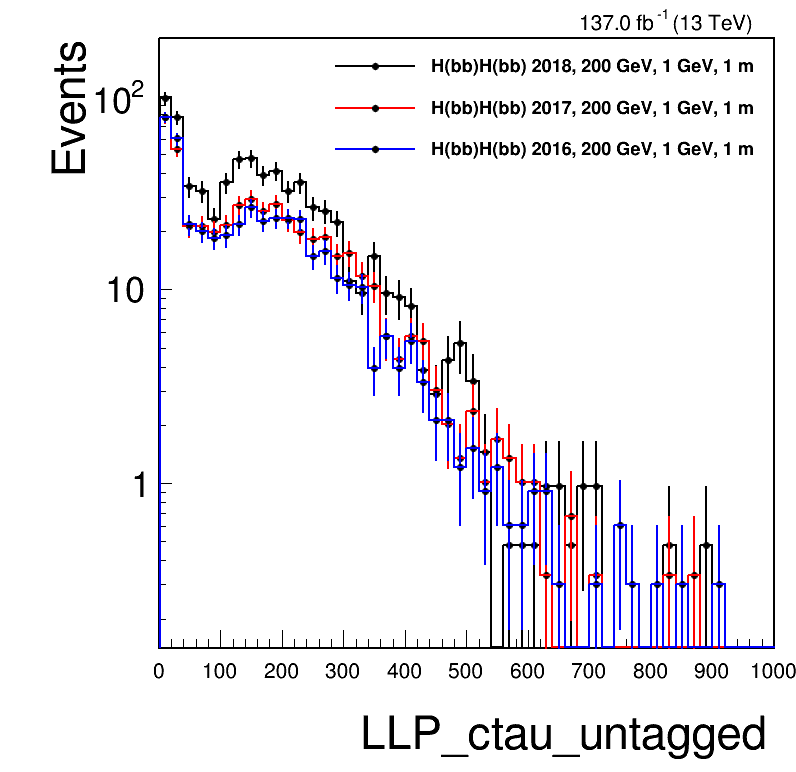

In [16]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
#     outf=var[0]+'_bin2.png'
    outf=var[0]+'_bin1.png'
#     outf=var[0]+'.png'
    LUMI = 137000 
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    
    color_list = [845,806,861,876,597,625]
    
    i=0
    for k,v in tree.items():
        if '2016' in k:
            lumi=35922
        elif '2017' in k:
            lumi=41529
        elif '2018' in k:
            lumi=59740
        print(k)
        pt1 =  var[1][k] 
#         v = pt1.flatten()
        v = pt1 
        print(v[:10])
        w =  trg_untag_w[k] 
#         w = w.flatten()
        print(len(v))
#         w = trg_jet_w[k] 
        print(w[:10])
        print(len(w))
#         w = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set, weights=w*lumi )
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)

        i+=1

   
    leg.Draw()



    CMS_lumi.lumi_13TeV = str(LUMI/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
#     c.SetLogx()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

# Signal Yields

In [10]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    if '2016' in k:
        lumi=35922
    elif '2017' in k:
        lumi=41529
    elif '2018' in k:
        lumi=59740
#     print(k)
    EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
#     print(np.sum(EventW)*lumi)
    print(np.sum(EventW)*1)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventW)*lumi), 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
0.0007863318896852434
0.0010865243384614587
0.0008936672820709646
+--------------------------------------+----------------+-------------+-------------+
|                Sample                |     Weight     | Bin 2 Yield | Bin 2 Error |
+--------------------------------------+----------------+-------------+-------------+
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m | [8.06029e-06]  |    46.98    |     6.85    |
| H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m | [8.116029e-06] |    45.12    |     6.72    |
| H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m | [8.41607e-06]  |     32.1    |     5.67    |
+--------------------------------------+----------------+-------------+-------------+


In [11]:
table_txt = table.get_string()
with open(plotDir+'/SignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)

# Reweight CTAU

In [12]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight
#CW version already summmed 

In [20]:
# def weight_calc(llp_ct, new_ctau, old_ctau):
#     ct_sum = llp_ct[0] + llp_ct[1]
#     print(ct_sum)
#     source = np.exp(-1.0*ct_sum/old_ctau)/old_ctau**2
#     weight = 1.0/new_ctau**2 * np.exp(-1.0*ct_sum/new_ctau)/source
#     return weight


In [22]:
# a=trg_jet_ctau[k][1]
# print(a)
# c=[x[0]+x[1]  for x in a]
# b=weight_calc(c, 100, 100)
# print(b)

In [13]:
#weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau[k]/10) # convert everything to cm
OLD_CTAU=1000 #mm
ECAL_R=129.0 #cm
EB_Z=268.3 #cm
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000])
# ctaus=np.array([1000])
EventReW = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
#         print(np.sum(EventW)*1)
        
#         weight_ctau = weight_calc(trg_jet_ctau[k][nTags[k]==2], float(ct)/10, OLD_CTAU/10) # convert everything to cm
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k][nTags[k]==2] ])
#         print(len(ctau_calc))
#         print(trg_jet_ctau[k][nTags[k]==2][:3])
#         print(ctau_calc[:3])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
#         print(EventW[:3])
#         print(weight_ctau[:3])
#         EventReW[k][ct] = [x*y for x,y in zip(EventW,weight_ctau)]
#         EventReW[k][ct] = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],weight_ctau)]
#         print(len(trg_jet_ctau[k][nTags[k]==2]))
#         print(len(trg_jet_w[k][nTags[k]==2]))
#         print(len(weight_ctau))
#         print(len(trg_jet_puw[k][nTags[k]==2]))
        EventReW[k][ct] =  trg_jet_w[k][nTags[k]==2]*weight_ctau*trg_jet_puw[k][nTags[k]==2]
#         print(EventReW[k][ct][:3])
#         print(np.sum(EventReW[k][ct]))
#         print(len(EventW))
#         print(len(weight_ctau))
#         print(len(EventReW[k][ct]))


H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
ctau 1  mm
ctau 3  mm
ctau 5  mm
ctau 7  mm
ctau 10  mm
ctau 30  mm
ctau 40  mm
ctau 50  mm
ctau 60  mm
ctau 80  mm
ctau 100  mm
ctau 200  mm
ctau 300  mm
ctau 400  mm
ctau 500  mm
ctau 600  mm
ctau 700  mm
ctau 800  mm
ctau 900  mm
ctau 950  mm
ctau 980  mm
ctau 1100  mm
ctau 1200  mm
ctau 1300  mm
ctau 1400  mm
ctau 1500  mm
ctau 2000  mm
ctau 3000  mm
ctau 4000  mm
ctau 5000  mm
ctau 10000  mm
ctau 20000  mm
ctau 30000  mm
ctau 50000  mm
ctau 100000  mm
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
ctau 1  mm
ctau 3  mm
ctau 5  mm
ctau 7  mm
ctau 10  mm
ctau 30  mm
ctau 40  mm
ctau 50  mm
ctau 60  mm
ctau 80  mm
ctau 100  mm
ctau 200  mm
ctau 300  mm
ctau 400  mm
ctau 500  mm
ctau 600  mm
ctau 700  mm
ctau 800  mm
ctau 900  mm
ctau 950  mm
ctau 980  mm
ctau 1100  mm
ctau 1200  mm
ctau 1300  mm
ctau 1400  mm
ctau 1500  mm
ctau 2000  mm
ctau 3000  mm
ctau 4000  mm
ctau 5000  mm
ctau 10000  mm
ctau 20000  mm
ctau 30000  mm
ctau 50000  mm
ctau 100000  mm
H(bb

In [14]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    if '2016' in k:
        lumi=35922
    elif '2017' in k:
        lumi=41529
    elif '2018' in k:
        lumi=59740
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReW[k][ct])*lumi), 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------------------------------------+-----------+-------------+-------------+
|                Sample                | Ctau [mm] | Bin 2 Yield | Bin 2 Error |
+--------------------------------------+-----------+-------------+-------------+
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     1     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     3     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     5     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     7     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     10    |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     30    |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     40    |     0.0     |     0.03    |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     50    |     0.01    |     0.11    |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |    

In [15]:
table_txt = table.get_string()
with open(plotDir+'/CTAUSignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)